# Milestone 3: RNN Notebook
In this notebook, we will train  LSTM models to predict our target variable without the lagged ones.


In [68]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
from google.colab import drive
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
import joblib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings, os
warnings.filterwarnings("ignore")

In [69]:
# mount drive and retrieve pickled data
drive.mount('/content/drive')
datadir = '/content/drive/MyDrive/Colab Notebooks/miso_project/data_pickled/'
df_final = pd.read_pickle(os.path.join(datadir, 'df_final_working.pkl'))
display(df_final.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21378 entries, 0 to 21377
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Timestamp                  21378 non-null  datetime64[ns]
 1   Illinois RTLMP Target      21378 non-null  float64       
 2   Arkansas RTLMP             21378 non-null  float64       
 3   Arkansas RTLMP_k23         21378 non-null  float64       
 4   Illinois RTLMP             21378 non-null  float64       
 5   Illinois RTLMP_k1          21378 non-null  float64       
 6   Illinois RTLMP_k2          21378 non-null  float64       
 7   Illinois RTLMP_k3          21378 non-null  float64       
 8   Illinois RTLMP_k23         21378 non-null  float64       
 9   Indiana RTLMP              21378 non-null  float64       
 10  I

None

# Split data
I will split the data chronologically to avoid leakage:
- Train: earliest 70%
- Validation: next 15%
- Test: last 15%

In [70]:
n = len(df_final)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)   # 70% + 15%

train_df = df_final.iloc[:train_end].copy()
val_df   = df_final.iloc[train_end:val_end].copy()
test_df  = df_final.iloc[val_end:].copy()

# Scale Data
Recall our observations about the distributions of the features from the previous notebook:

### Loads
**Summary:** The distribution is approximately Gaussian in its central mass but has an additional one-sided tail toward larger load values; the tail is present but less extreme than for prices.

**Interpretation:** This suggests a near-normal baseline demand pattern with some high-load episodes (positive skew). I think regular normalization with mean and standard deviation would suffice. We will use `StandardScaler`.

### Price Features
**Summary**: The distribution has a small mean, with most observations concentrated near the mean, includes some negative values, and exhibits a very long, sparse tail toward larger values.

**Interpretation**: This indicates strong positive skewness, which is maybe driven by occasional extreme high-price events. The presence of negative values also suggest there is a load imbalance in the system. The long right tail implies outliers and non-normality, so we may need robust scaling and/or a transformation. We will use `PowerTransformer(method="yeo-johnson")`, which handles negatives, then `RobustScaler`.


**Summary:** The distribution resembles a Gaussian mixture with two modes, consistent with two underlying regimes (cold-weather and hot-weather conditions).

**Interpretation:** This implies the data are generated by at least two distinct temperature regimes rather than a single unimodal process. However, I will use a naive normalization for these data. We will use `StandardScaler`.


In [71]:
TARGET_COL = "Illinois RTLMP Target"

PRICE_COLS = [
    "Arkansas RTLMP", "Illinois RTLMP", "Indiana RTLMP", "Michigan RTLMP",
    "Arkansas DALMP_k-1", "Illinois DALMP_k-1", "Indiana DALMP_k-1", "Michigan DALMP_k-1",
]

LOAD_COLS = [
    "Total Actual Load",
    "Total Forecast Load_k-1",
    "LRZ 4_forecast_k-1",
    "LRZ 8_ 9_ 10_forecast_k-1",
]

TEMP_COLS = [
    "Argonne_temp_k-1",
    "Indianapolis_temp_k-1",
]

CYC_COLS = [
    "week_sin_k-1", "week_cos_k-1",
    "hour_sin_k-1", "hour_cos_k-1",
    "month_sin_k-1", "month_cos_k-1",
]

Let's split features and target, and drop Timestamp.

In [72]:
X_train = train_df.drop(columns=["Timestamp", TARGET_COL]).copy()
y_train = train_df[TARGET_COL].copy()

X_val = val_df.drop(columns=["Timestamp", TARGET_COL]).copy()
y_val = val_df[TARGET_COL].copy()

X_test = test_df.drop(columns=["Timestamp", TARGET_COL]).copy()
y_test = test_df[TARGET_COL].copy()

Define the data processing pipelines:

In [73]:
price_pipe = Pipeline(steps=[
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("robust", RobustScaler()),
])

load_pipe = Pipeline(steps=[
    ("std", StandardScaler()),
])

temp_pipe = Pipeline(steps=[
    ("std", StandardScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("price", price_pipe, PRICE_COLS),
        ("load",  load_pipe,  LOAD_COLS),
        ("temp",  temp_pipe,  TEMP_COLS),
        ("cyc",   "passthrough", CYC_COLS),
    ],
    remainder="drop"
)

y_scaler = Pipeline(steps=[
    ("power", PowerTransformer(method="yeo-johnson", standardize=False)),
    ("robust", RobustScaler()),
])

We will fit only on the training set to prevent data leakage. For the rest, we will only transform based on our training data fit.  Note that we will later use `y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()` to inverse our transform.

In [74]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_val_scaled   = preprocessor.transform(X_val)
X_test_scaled  = preprocessor.transform(X_test)

# Target variable
y_train_scaled = y_scaler.fit_transform(y_train.to_frame()).ravel()
y_val_scaled   = y_scaler.transform(y_val.to_frame()).ravel()
y_test_scaled  = y_scaler.transform(y_test.to_frame()).ravel()

def inverse_y(y_scaled_1d):
    # y_scaler expects shape (n, 1)
    return y_scaler.inverse_transform(y_scaled_1d.reshape(-1, 1)).ravel()

In [75]:
joblib.dump(preprocessor, "X_preprocessor.joblib")
joblib.dump(y_scaler, "y_scaler.joblib")

dataset_scaled = {
    "X_train": X_train_scaled, "y_train": y_train_scaled,
    "X_val":   X_val_scaled,   "y_val":   y_val_scaled,
    "X_test":  X_test_scaled,  "y_test":  y_test_scaled,
}

joblib.dump(dataset_scaled, "dataset_scaled.joblib")

print("Done.")
print("Shapes:")
print("X_train:", X_train_scaled.shape, "y_train:", y_train_scaled.shape)
print("X_val:  ", X_val_scaled.shape,   "y_val:  ", y_val_scaled.shape)
print("X_test: ", X_test_scaled.shape,  "y_test: ", y_test_scaled.shape)


Done.
Shapes:
X_train: (14964, 20) y_train: (14964,)
X_val:   (3207, 20) y_val:   (3207,)
X_test:  (3207, 20) y_test:  (3207,)


# LSTM Model: Without Lagged Features
## Discussion on Evaluation of Success and Model
We have hourly time series, multivariate exogenous features (loads, temps, calendar Fourier terms, other node prices), and heavy-tailed electricity prices with occasional spikes/regime shifts. Unlike an MLP (fixed tabular snapshot), an LSTM can exploit temporal dependence by ingesting a sequence window of past hours.
### **Metric for prediction success**
I will report Report both MAE and RMSE (in $/MWh) after inverse-transforming predictions back to original price units. Because both are very interpretable. MAE is robust to outliers compared to RMSE so it will explain our success on average days. RMSE penalizes large misses more. This shows whether spikes are being badly missed. In particular, we early-stop on validation MAE to prioritize typical-hour accuracy, and report RMSE to quantify spike sensitivity.

#### **Algorithm**
 We will use an `LSTM`.

Instead of feeding a single row of features, we should create an input tensor:

- `X` with shape (batch, seq_len, n_features)
- `y` with shape: (batch, 1)

Here, `seq_len` is our lookback window and it is a design choice. Typical starting points are:`seq_len = 24,48,168`.

However, recall that we didn't observe high Spearman correlation with the previous week's values. So, we will choose `seq_len = 48`.


#### **Architecture**

- **Encoder:** 2 stacked LSTM layers  
- **Hidden size:** 128  
- **Dropout:** 0.1 (between LSTM layers and/or on the final head)  
- **Head:** small MLP mapping the final hidden state -> 1 output  
- **Sequence pooling choice:** We will use the last output so that we can use the recent history to forecast the next step.

We will choose these values because we don't need to go too deep since we have ~21k hourly data. This is not a big value for in the deep learning research scale. LSTMs can overfit if too large, especially with heavy tails and regime shifts. A compact model is usually more stable.


#### **Optimizer and Scheduler**

We will use `AdamW(lr=5e-4, weight_decay=1e-4,clip_grad_norm_ = 1.0)` is a solid default. We use this over `Adam` because AdamW decouples the weight decay from the from the gradient-based update, making regularization more consistent and easier to tune.

We use `Gradient clipping` because it is important for RNNs to avoid exploding gradients.

**Scheduler:** `ReduceLROnPlateau` on **validation MAE**, same logic as for MLP.



#### **Regularization**

We use:
- **Weight decay** (via AdamW)
- **Dropout** (LSTM dropout + head dropout)
- **Early stopping** (validation MAE)
- **Gradient clipping** (stability regularizer for RNNs)


#### **Choice of cost function**
We will use suggests Huber loss, which has:
- MSE-like near small errors (smooth gradients)
- MAE-like for large errors (robust to spikes)






# Training the Model

In [76]:
# Let's make sure the project is reproducable
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Prepare the sequence datasets.

In [77]:
X_train_np = np.asarray(X_train_scaled, dtype=np.float32)
X_val_np   = np.asarray(X_val_scaled, dtype=np.float32)
X_test_np  = np.asarray(X_test_scaled, dtype=np.float32)

y_train_np = np.asarray(y_train_scaled, dtype=np.float32)
y_val_np   = np.asarray(y_val_scaled, dtype=np.float32)
y_test_np  = np.asarray(y_test_scaled, dtype=np.float32)

print("X_train:", X_train_np.shape, "y_train:", y_train_np.shape)
print("X_val:  ", X_val_np.shape,   "y_val:  ", y_val_np.shape)
print("X_test: ", X_test_np.shape,  "y_test: ", y_test_np.shape)

# Sequence dataset

class SequenceDataset(Dataset):
    """
    Builds sequences of length seq_len from X, with target y aligned
    to the LAST row of the sequence (one-step-ahead already encoded
    via your lagged features).
    """
    def __init__(self, X_2d: np.ndarray, y_1d: np.ndarray, seq_len: int):
        assert X_2d.ndim == 2
        assert y_1d.ndim == 1
        assert len(X_2d) == len(y_1d)
        assert seq_len >= 2
        self.X = X_2d
        self.y = y_1d
        self.seq_len = seq_len

    def __len__(self):
        # sequences end at indices [seq_len-1, ..., n-1]
        return len(self.X) - self.seq_len + 1

    def __getitem__(self, idx):
        end = idx + self.seq_len
        x_seq = self.X[idx:end]                 # (seq_len, n_features)
        y_t   = self.y[end - 1]                 # scalar (aligned to last step)
        return torch.from_numpy(x_seq), torch.tensor(y_t, dtype=torch.float32)

X_train: (14964, 20) y_train: (14964,)
X_val:   (3207, 20) y_val:   (3207,)
X_test:  (3207, 20) y_test:  (3207,)


In [78]:
# LSTM Model
class LSTMRegressor(nn.Module):
    def __init__(self, n_features: int, hidden_size: int = 128, num_layers: int = 2,
                 dropout: float = 0.2, head_dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True
        )
        self.head = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.LeakyReLU(0.01),
            nn.Dropout(head_dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: (batch, seq_len, n_features)
        out, _ = self.lstm(x)          # out: (batch, seq_len, hidden)
        last = out[:, -1, :]           # (batch, hidden)
        yhat = self.head(last)         # (batch, 1)
        return yhat.squeeze(-1)        # (batch,)

In [79]:

#  Metrics in original units
def mae_rmse_original_units(y_true_scaled_1d, y_pred_scaled_1d):
    y_true = inverse_y(np.asarray(y_true_scaled_1d, dtype=np.float32))
    y_pred = inverse_y(np.asarray(y_pred_scaled_1d, dtype=np.float32))
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return float(mae), float(rmse)

In [80]:
@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval()
    losses = []
    y_true_all = []
    y_pred_all = []

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        pred = model(xb)
        loss = loss_fn(pred, yb)

        losses.append(loss.item())
        y_true_all.append(yb.detach().cpu().numpy())
        y_pred_all.append(pred.detach().cpu().numpy())

    y_true_all = np.concatenate(y_true_all)
    y_pred_all = np.concatenate(y_pred_all)

    val_loss = float(np.mean(losses))
    val_mae, val_rmse = mae_rmse_original_units(y_true_all, y_pred_all)
    return val_loss, val_mae, val_rmse

In [81]:

# Early stopping on val MAE

class EarlyStopping:
    def __init__(self, patience=20, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = np.inf
        self.num_bad = 0
        self.best_state = None

    def step(self, current, model):
        improved = (self.best - current) > self.min_delta
        if improved:
            self.best = current
            self.num_bad = 0
            # store best weights on CPU to avoid GPU memory growth
            self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.num_bad += 1
        return self.num_bad >= self.patience

    def restore_best(self, model):
        if self.best_state is not None:
            model.load_state_dict(self.best_state)

In [82]:

#  Hyperparameters ( our design choices)

seq_len     = 24
batch_size  = 256
max_epochs  = 200

hidden_size = 128
num_layers  = 2
dropout     = 0.2
head_dropout= 0.2

lr          = 1e-3
weight_decay= 1e-4
clip_norm   = 1.0

In [83]:
# DataLoaders
train_ds = SequenceDataset(X_train_np, y_train_np, seq_len=seq_len)
val_ds   = SequenceDataset(X_val_np,   y_val_np,   seq_len=seq_len)
test_ds  = SequenceDataset(X_test_np,  y_test_np,  seq_len=seq_len)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

n_features = X_train_np.shape[1]
model = LSTMRegressor(
    n_features=n_features,
    hidden_size=hidden_size,
    num_layers=num_layers,
    dropout=dropout,
    head_dropout=head_dropout
).to(device)

print(model)

LSTMRegressor(
  (lstm): LSTM(20, 128, num_layers=2, batch_first=True, dropout=0.2)
  (head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [84]:
# Loss / Optim / Scheduler
loss_fn = nn.HuberLoss(delta=1.0)  # Huber
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

early_stopper = EarlyStopping(patience=20, min_delta=0.0)

In [85]:
#  Train loop
history = {
    "train_loss": [],
    "val_loss": [],
    "val_mae": [],
    "val_rmse": [],
    "lr": []
}

for epoch in range(1, max_epochs + 1):
    model.train()
    train_losses = []

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()

        # gradient clipping for RNN stability
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)

        optimizer.step()
        train_losses.append(loss.item())

    train_loss = float(np.mean(train_losses))
    val_loss, val_mae, val_rmse = evaluate(model, val_loader, loss_fn)

    # ReduceLROnPlateau on validation MAE (your design choice)
    scheduler.step(val_mae)

    # logging
    current_lr = optimizer.param_groups[0]["lr"]
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_mae"].append(val_mae)
    history["val_rmse"].append(val_rmse)
    history["lr"].append(current_lr)

    print(
        f"Epoch {epoch:03d} | "
        f"train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | "
        f"val_MAE=${val_mae:.3f}/MWh | val_RMSE=${val_rmse:.3f}/MWh | lr={current_lr:.2e}"
    )

    # early stopping on validation MAE (in original units)
    should_stop = early_stopper.step(val_mae, model)
    if should_stop:
        print(f"Early stopping triggered at epoch {epoch}. Best val MAE=${early_stopper.best:.3f}/MWh")
        break

# restore best model
early_stopper.restore_best(model)

# Final evaluation on test
test_loss, test_mae, test_rmse = evaluate(model, test_loader, loss_fn)
print(f"\nTEST | loss={test_loss:.4f} | MAE=${test_mae:.3f}/MWh | RMSE=${test_rmse:.3f}/MWh")

Epoch 001 | train_loss=0.1587 | val_loss=0.1309 | val_MAE=$11.430/MWh | val_RMSE=$65.118/MWh | lr=1.00e-03
Epoch 002 | train_loss=0.1086 | val_loss=0.1156 | val_MAE=$10.705/MWh | val_RMSE=$64.059/MWh | lr=1.00e-03
Epoch 003 | train_loss=0.0983 | val_loss=0.1111 | val_MAE=$10.226/MWh | val_RMSE=$63.522/MWh | lr=1.00e-03
Epoch 004 | train_loss=0.0950 | val_loss=0.1103 | val_MAE=$10.266/MWh | val_RMSE=$64.352/MWh | lr=1.00e-03
Epoch 005 | train_loss=0.0932 | val_loss=0.1120 | val_MAE=$10.526/MWh | val_RMSE=$65.368/MWh | lr=1.00e-03
Epoch 006 | train_loss=0.0911 | val_loss=0.1135 | val_MAE=$10.741/MWh | val_RMSE=$66.754/MWh | lr=1.00e-03
Epoch 007 | train_loss=0.0918 | val_loss=0.1129 | val_MAE=$10.763/MWh | val_RMSE=$66.132/MWh | lr=1.00e-03
Epoch 008 | train_loss=0.0907 | val_loss=0.1104 | val_MAE=$10.114/MWh | val_RMSE=$65.488/MWh | lr=1.00e-03
Epoch 009 | train_loss=0.0889 | val_loss=0.1118 | val_MAE=$10.214/MWh | val_RMSE=$66.182/MWh | lr=1.00e-03
Epoch 010 | train_loss=0.0887 | val_l

# Prediction Results

In [89]:
@torch.no_grad()
def predict_scaled(model, loader):
    model.eval()
    preds = []
    trues = []
    for xb, yb in loader:
        xb = xb.to(device)
        pred = model(xb).detach().cpu().numpy()
        preds.append(pred)
        trues.append(yb.numpy())
    return np.concatenate(trues), np.concatenate(preds)

y_test_seq_scaled, yhat_test_seq_scaled = predict_scaled(model, test_loader)
y_val_seq_scaled, yhat_val_seq_scaled = predict_scaled(model, val_loader)
y_train_seq_scaled, yhat_train_seq_scaled = predict_scaled(model, train_loader)

y_test_seq = inverse_y(y_test_seq_scaled)
yhat_test_seq = inverse_y(yhat_test_seq_scaled)

y_val_seq = inverse_y(y_val_seq_scaled)
yhat_val_seq = inverse_y(yhat_val_seq_scaled)

y_train_seq = inverse_y(y_train_seq_scaled)
yhat_train_seq = inverse_y(yhat_train_seq_scaled)

#timesteps
train_ts = train_df["Timestamp"].values
val_ts   = val_df["Timestamp"].values
test_ts  = test_df["Timestamp"].values



In [90]:
def plot_split(ts, seq_len, y_true, y_pred, split_name):
    ts = ts[seq_len-1:]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    plt.figure(figsize=(16, 4))
    plt.plot(ts, y_true, label="Real", linewidth=1.2)
    plt.plot(ts, y_pred, label="Prediction", linewidth=1.2)

    plt.title(f"{split_name} - MAE={mae:.2f}  - RMSE={rmse:.2f} ")
    plt.xlabel("Timestamp")
    plt.ylabel("Illinois RTLMP ($/MWh)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

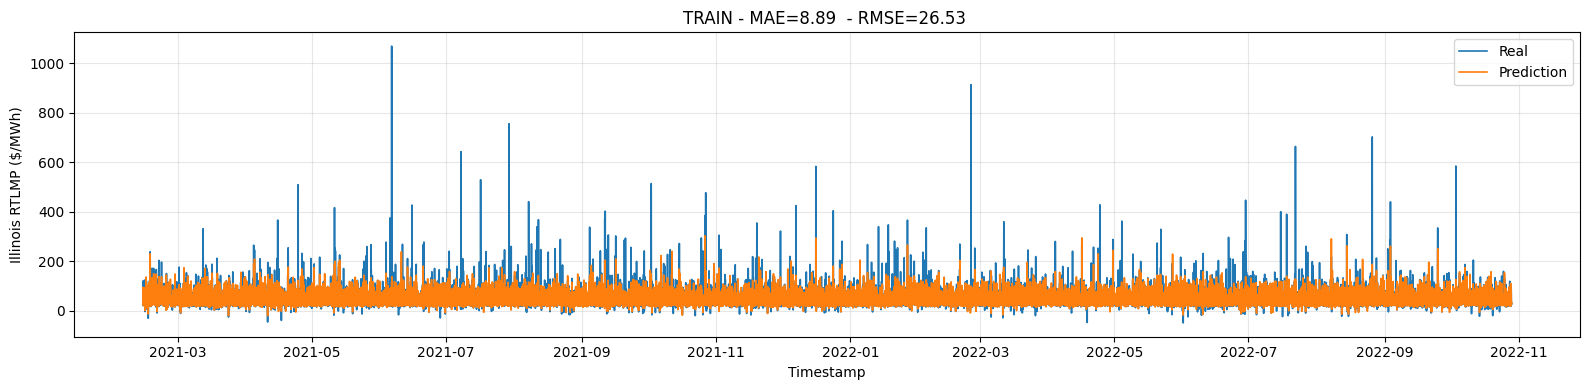

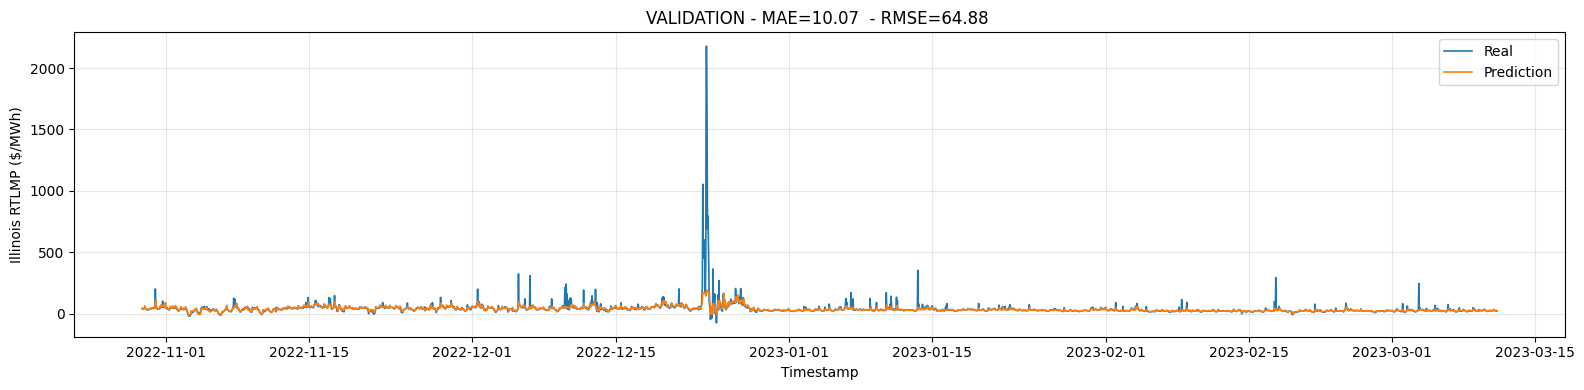

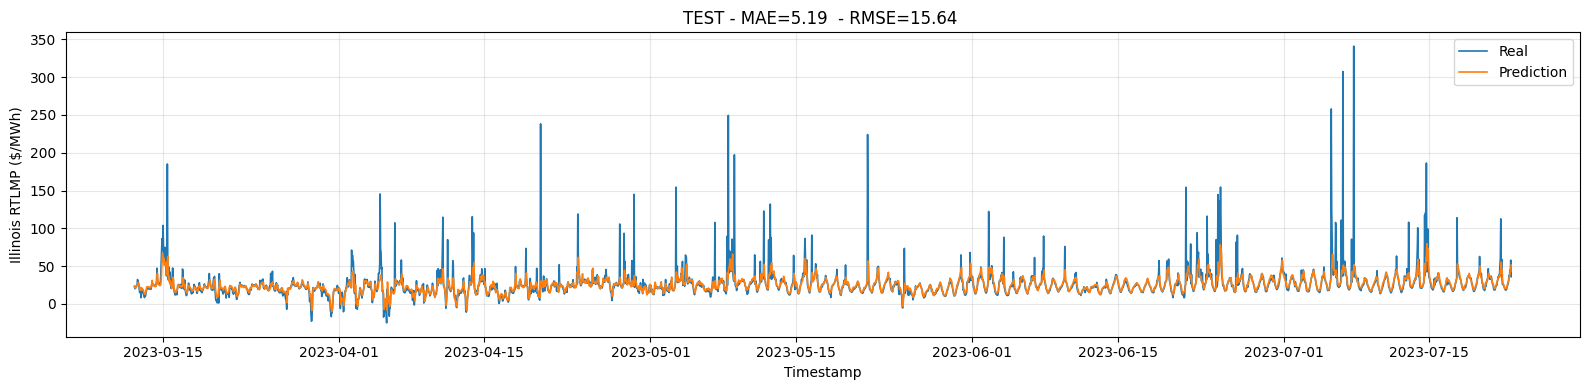

In [92]:
plot_split(train_ts, seq_len, y_train_seq, yhat_train_seq, "TRAIN")
plot_split(val_ts, seq_len,  y_val_seq, yhat_val_seq,   "VALIDATION")
plot_split(test_ts, seq_len, y_test_seq, yhat_test_seq,  "TEST")